# Pretrain attractor network OSP

In [1]:
%load_ext lab_black
import tensorflow as tf
import numpy as np
import pandas as pd

In [8]:
code_name = 'Attractor_50'
sample_name = 'hs04'
sample_rng_seed = 329
tf_rng_seed = 1234

# Model architechture
pho_units = 250
cleanup_units = 50
rnn_activation = 'sigmoid'
tau = 0.2
max_unit_time = 4.

# Training
n_mil_sample = 5.  # 1 mil can only reach 50-60% correct
batch_size = 128
learning_rate = 0.001
save_freq = 5

In [9]:
from meta import model_cfg
# cfg = model_cfg(code_name=None)
# cfg.load_cfg_json('models/Attractor_100/model_config.json')

cfg = model_cfg(
    code_name=code_name,
    sample_name=sample_name,
    sample_rng_seed=sample_rng_seed,
    tf_rng_seed=tf_rng_seed,
    pho_units=pho_units,
    cleanup_units=cleanup_units,
    tau=tau,
    max_unit_time=max_unit_time,
    n_mil_sample=n_mil_sample,
    batch_size=batch_size,
    rnn_activation=rnn_activation,
    learning_rate=learning_rate,
    save_freq=save_freq
)

# Global TF seed (Sampling is out of TF scope...)
tf.random.set_seed(cfg.tf_rng_seed)

In [10]:
from tensorflow.keras import Model
from tensorflow.keras.layers import Layer, Input
from modeling import attractor_rnn
from tensorflow.keras.optimizers import Adam

clamp_steps = 14

input_o = Input(shape=(cfg.pho_units, ))
rnn_model = attractor_rnn(cfg, clamp_steps)(input_o)
model = Model(input_o, rnn_model)

model.compile(
    loss='binary_crossentropy',
    optimizer=Adam(
        learning_rate=cfg.learning_rate,
        beta_1=0.9,
        beta_2=0.999,
        amsgrad=False
    ),
    metrics=['BinaryAccuracy', 'mse']
)
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 250)]             0         
_________________________________________________________________
rnn (attractor_rnn)          [(None, 250), (None, 250) 87800     
Total params: 87,800
Trainable params: 87,800
Non-trainable params: 0
_________________________________________________________________


In [11]:
model.save_weights(cfg.path_weight_folder + 'ep0000.h5')

In [ ]:
from keras.callbacks import ModelCheckpoint
import h5py, pickle, os
from IPython.display import clear_output

from data_wrangling import my_data
data = my_data(cfg)

checkpoint = ModelCheckpoint(cfg.path_weights_checkpoint, verbose=1, 
                             period=cfg.save_freq, save_weights_only=True) 


def sample_gen4attractor(x_set, y_set, n_timesteps, batch_size, sample_p, rng_seed):
# Get <batch_size> of data from <x_set>, <y_set> based on the probability of <sample_p>
    np.random.seed(rng_seed)
    while 1:
        idx = np.random.choice(range(len(sample_p)), batch_size, p=sample_p)
        batch_x = x_set[idx]
        batch_y = []
        
        for i in range(n_timesteps):
            batch_y.append(y_set[idx])
        yield (batch_x, batch_y)


history = model.fit(sample_gen4attractor(data.y_train, data.y_train, 
                                    cfg.n_timesteps - 14, cfg.batch_size, 
                                    data.sample_p, cfg.sample_rng_seed),
                                    steps_per_epoch = cfg.steps_per_epoch,
                                    epochs = cfg.nEpo,
                                    verbose=0,  
                                    callbacks=[checkpoint])


# Saving history and model
pickle_out = open(cfg.path_history_pickle,"wb")
pickle.dump(history.history, pickle_out)
pickle_out.close()

clear_output()
print('Training done')

In [6]:
from evaluate import training_history

hist = training_history(cfg.path_history_pickle)
hist.plot_all(cfg.path_plot_folder + 'history.html')

alt.HConcatChart(...)

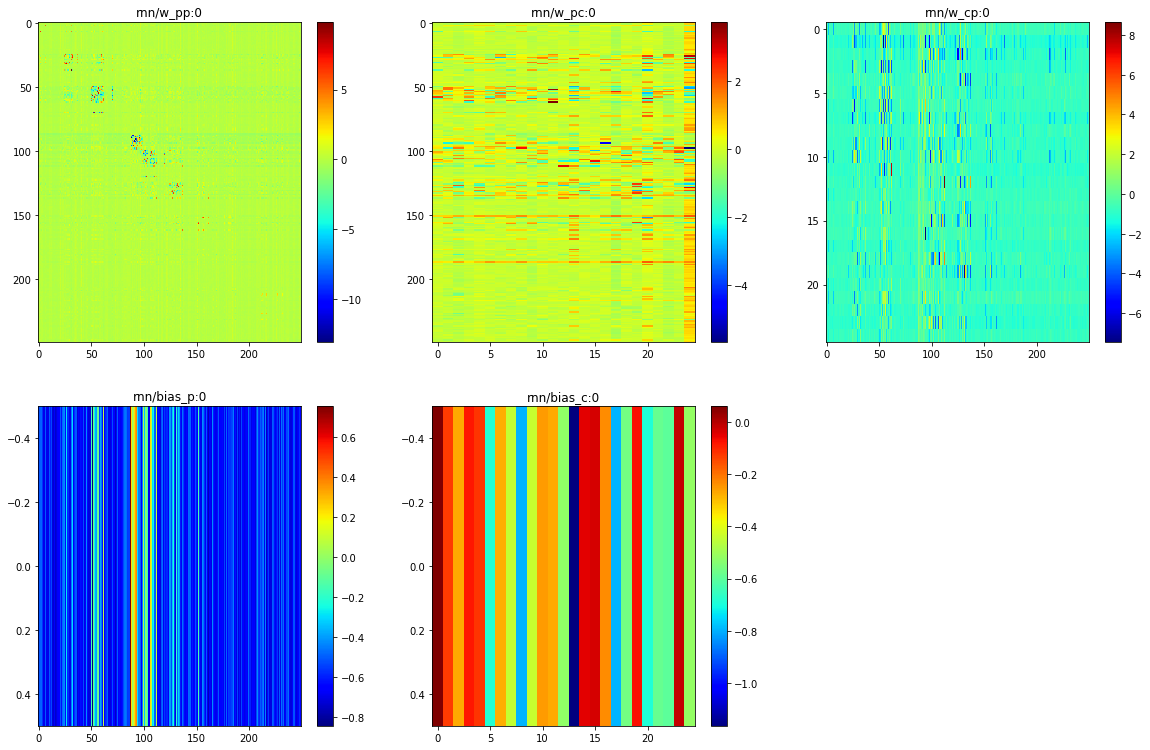

In [7]:
from evaluate import plot_variables
plot_variables(model)

In [8]:
from evaluate import get_all_pronunciations_fast


def attractor_acc(model, data, timestep, verbose):
    # Timestep is counting from the first unclapped time point
    y_pred_matrix = model.predict(data.y_strain)
    y_pred = get_all_pronunciations_fast(
        y_pred_matrix[-1], data.phon_key
    )  # Prediction at last time step
    y_true = get_all_pronunciations_fast(data.y_strain, data.phon_key)

    correct = []
    incorrect = []
    incorrect_ans = []
    for i, x in enumerate(y_pred):
        if y_pred[i] == y_true[i]:
            correct.append(y_pred[i])
        else:
            incorrect.append(y_pred[i])
            incorrect_ans.append(y_true[i])

    c_rate = len(correct) / len(y_pred)

    if verbose == True:
        print(
            'Correct preditions {} % \n They are: {} \n'.format(
                100 * c_rate, correct
            )
        )

        print(
            'Incorrect preditions {} % \n They are {} \n'.format(
                100 * len(incorrect) / len(y_pred), incorrect
            )
        )
        print('Correct answer should be: {}'.format(incorrect_ans))

    return len(correct) / len(y_pred)


def attractor_dev(model, cfg, data):
    acc = []
    for weights_h5 in cfg.path_weights_list:
        model.load_weights(weights_h5)
        acc.append(attractor_acc(model, data, cfg.n_timesteps - 1, False))

    return acc


def get_epoch_where_p_more_than(epoch_list, acc_list, x):
    return epoch_list[np.min(np.where(np.array(acc_list) > x))]


acc = attractor_dev(model, cfg, data)

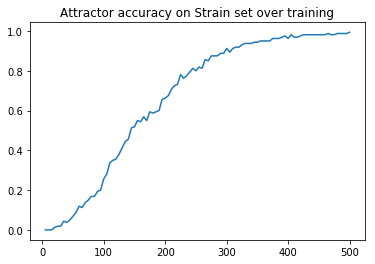

Accuracy reach 0.6 at epoch: 195
Accuracy reach 0.8 at epoch: 245
Accuracy reach 0.9 at epoch: 300
Accuracy reach 0.95 at epoch: 375


In [9]:
import matplotlib.pyplot as plt

plt.plot(cfg.saved_epoch_list, acc)
plt.title('Attractor accuracy on Strain set over training')
plt.show()

print(
    'Accuracy reach 0.6 at epoch: {}'.format(
        get_epoch_where_p_more_than(cfg.saved_epoch_list, acc, 0.6)
    )
)
print(
    'Accuracy reach 0.8 at epoch: {}'.format(
        get_epoch_where_p_more_than(cfg.saved_epoch_list, acc, 0.8)
    )
)
print(
    'Accuracy reach 0.9 at epoch: {}'.format(
        get_epoch_where_p_more_than(cfg.saved_epoch_list, acc, 0.9)
    )
)
print(
    'Accuracy reach 0.95 at epoch: {}'.format(
        get_epoch_where_p_more_than(cfg.saved_epoch_list, acc, 0.95)
    )
)

In [ ]:
!jupyter nbconvert --to html --output-dir=$cfg.path_model_folder train_attractor.ipynb